In [7]:
!pip install pandas numpy torch transformers datasets scikit-learn matplotlib seaborn
!pip install accelerate

📥 Loading filtered Excel dataset...
✅ Loaded dataset with 109810 rows

🔀 Splitting dataset into 80% train, 20% test...
✅ Train size: 87848, Test size: 21962

⚖️ Computing class weights...
✅ Class weights: [0.6860123872756958, 1.8439966440200806]

🔤 Tokenizing text...
✅ Tokenization complete.

🧠 Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/common/home/projectgrps/IS424/IS424G4/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



🚦 Training started...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.399000,0.390339,0.859393,0.738172,0.745504,0.730982
2,0.279700,0.390980,0.846143,0.739656,0.683371,0.806045
3,0.226600,0.491413,0.867271,0.750748,0.764808,0.737196


✅ Training complete.

📈 Evaluating on test set...



📊 Classification Report:
              precision    recall  f1-score   support

    SUPPORTS   0.900639  0.907166  0.903890     16007
     REFUTES   0.745504  0.730982  0.738172      5955

    accuracy                       0.859393     21962
   macro avg   0.823072  0.819074  0.821031     21962
weighted avg   0.858574  0.859393  0.858956     21962


🧮 Confusion Matrix:
[[14521  1486]
 [ 1602  4353]]


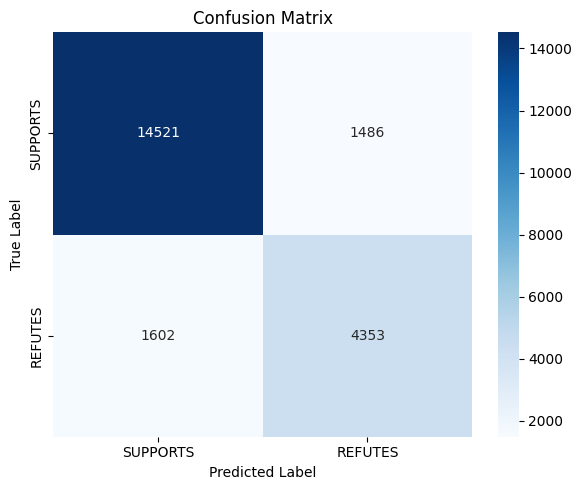


📐 ROC AUC Score: 0.911406


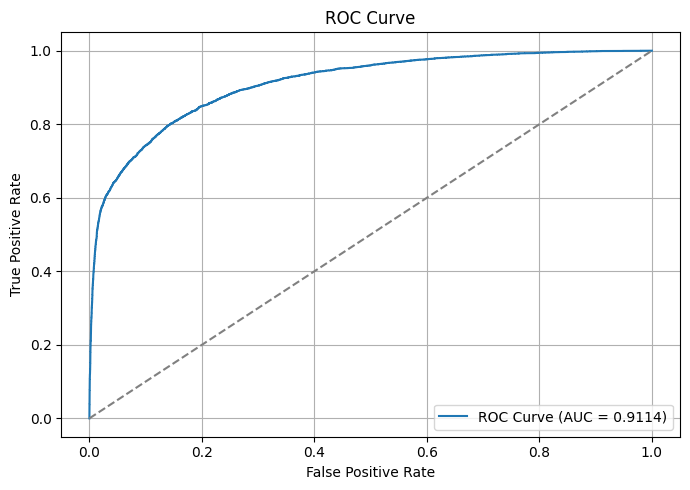

In [ ]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import re
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score, roc_curve
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F


# Load filtered Excel dataset
print("📥 Loading filtered Excel dataset...")
df = pd.read_excel("../data/filtered_fever_data.xlsx")
df = df[df["label"].isin(["SUPPORTS", "REFUTES"])]
df["label"] = df["label"].map({"SUPPORTS": 0, "REFUTES": 1})
print(f"Loaded dataset with {len(df)} rows")


# Train-Test Split (80/20)
print("\nSplitting dataset into 80% train, 20% test...")
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


# Compute Class Weights

print("\nComputing class weights...")
class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=train_df["label"].values)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class weights: {class_weights.tolist()}")


# Tokenization
print("\nTokenizing text...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_df["claim"].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_df["claim"].tolist(), truncation=True, padding=True, max_length=128)
print("Tokenization complete.")

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_df["label"].tolist()
})
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_df["label"].tolist()
})

# Load BERT Model
print("\n🧠 Loading BERT model...")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Custom Trainer with Weighted Loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

#Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

#Trainer Initialization
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda pred: {
        "accuracy": accuracy_score(pred.label_ids, pred.predictions.argmax(-1)),
        "f1": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[2],
        "precision": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[0],
        "recall": precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='binary')[1],
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


# Train
print("\n🚦 Training started...")
trainer.train()
print("Training complete.")

# Evaluation
print("\nEvaluating on test set...")
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

# Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["SUPPORTS", "REFUTES"], digits=6))


print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["SUPPORTS", "REFUTES"], yticklabels=["SUPPORTS", "REFUTES"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC AUC and ROC Curve
# Get predicted probabilities for class 1 (SUPPORTS)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
y_probs = probs[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_true, y_probs)

# Print ROC AUC score
print(f"\nROC AUC Score: {roc_auc:.6f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


📥 Loading filtered dataset...
✅ Loaded 109810 rows


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/common/home/projectgrps/IS424/IS424G4/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



🚦 Training started...


Epoch,Training Loss,Validation Loss
1,0.100600,0.104483
2,0.072500,0.097159
3,0.036400,0.175028


✅ Training complete.



📊 Classification Report:
              precision    recall  f1-score   support

    SUPPORTS   0.914810  0.890236  0.902356     16007
     REFUTES   0.724824  0.777162  0.750081      5955

    accuracy                       0.859576     21962
   macro avg   0.819817  0.833699  0.826218     21962
weighted avg   0.863295  0.859576  0.861066     21962


🧮 Confusion Matrix:
[[14250  1757]
 [ 1327  4628]]

📐 ROC AUC Score: 0.918199


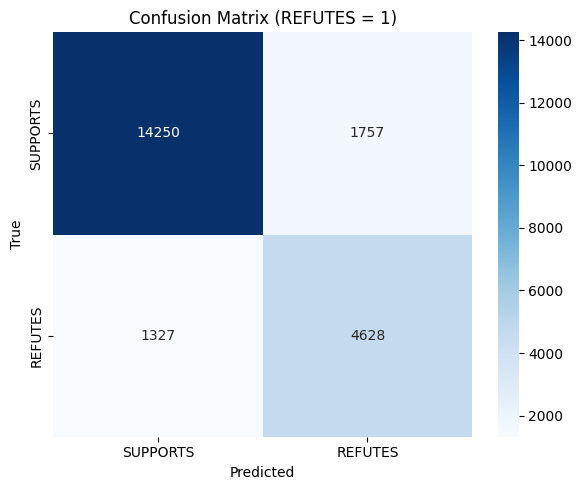

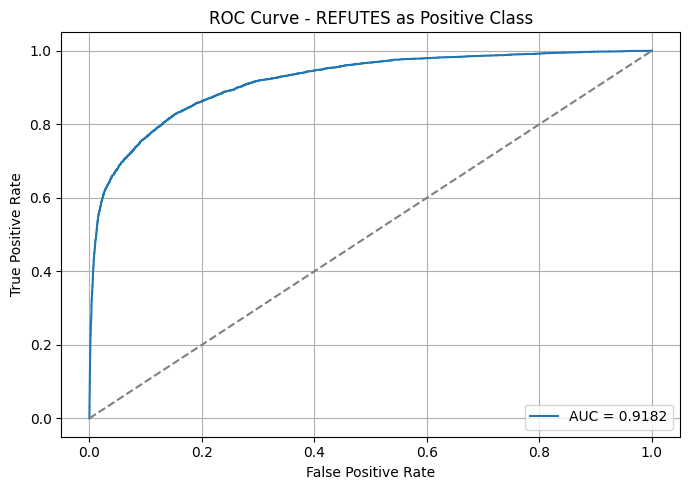

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score, roc_curve
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
print("Loading filtered dataset...")
df = pd.read_excel("../data/filtered_fever_data.xlsx")
df = df[df["label"].isin(["SUPPORTS", "REFUTES"])]
df["label"] = df["label"].map({"SUPPORTS": 0, "REFUTES": 1}) 
print(f"Loaded {len(df)} rows")

# Train-Test Split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_df["claim"].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_df["claim"].tolist(), truncation=True, padding=True, max_length=128)

train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_df["label"].tolist()
})
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_df["label"].tolist()
})

#Load BERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.alpha = alpha

    def forward(self, logits, labels):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(logits, labels)
        pt = torch.exp(-ce_loss)
        loss = (1 - pt) ** self.gamma * ce_loss
        if self.alpha is not None:
            at = self.alpha.gather(0, labels)
            loss = loss * at
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# Custom Trainer using Focal Loss
class FocalLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        alpha = torch.tensor([0.8, 1.5]).to(device)  
        loss_fn = FocalLoss(alpha=alpha, gamma=2)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

#Training Arguments
training_args = TrainingArguments(
    output_dir="./results_focal_refutes1",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    lr_scheduler_type="linear",
    gradient_accumulation_steps=2,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

#Trainer Init
trainer = FocalLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train
print("\nTraining started...")
trainer.train()
print("Training complete.")

# Evaluate
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["SUPPORTS", "REFUTES"], digits=6))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ROC AUC
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
y_probs = probs[:, 1]  # REFUTES = 1
roc_auc = roc_auc_score(y_true, y_probs)
print(f"\nROC AUC Score: {roc_auc:.6f}")

# Plots
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["SUPPORTS", "REFUTES"],
            yticklabels=["SUPPORTS", "REFUTES"])
plt.title("Confusion Matrix (REFUTES = 1)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - REFUTES as Positive Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
